# Optimal Scheduling of Battery Energy Storage System for Daily Cost Minimization

**Context:**
A consumer is equipped with a BESS and is subject to time-of-use electricity rates, which fluctuate throughout the day based on supply and demand dynamics.

**Problem:**
The consumer seeks to minimize their daily electricity cost by optimally deciding when to charge and discharge the BESS. The challenge lies in determining the optimal charging and discharging schedule that aligns with electricity price fluctuations while adhering to technical and operational constraints.

**Step 1: Setting Up Your Environment & Importing Libraries**

In [101]:
!pip install docplex pandas matplotlib
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Step 2: Setting data**

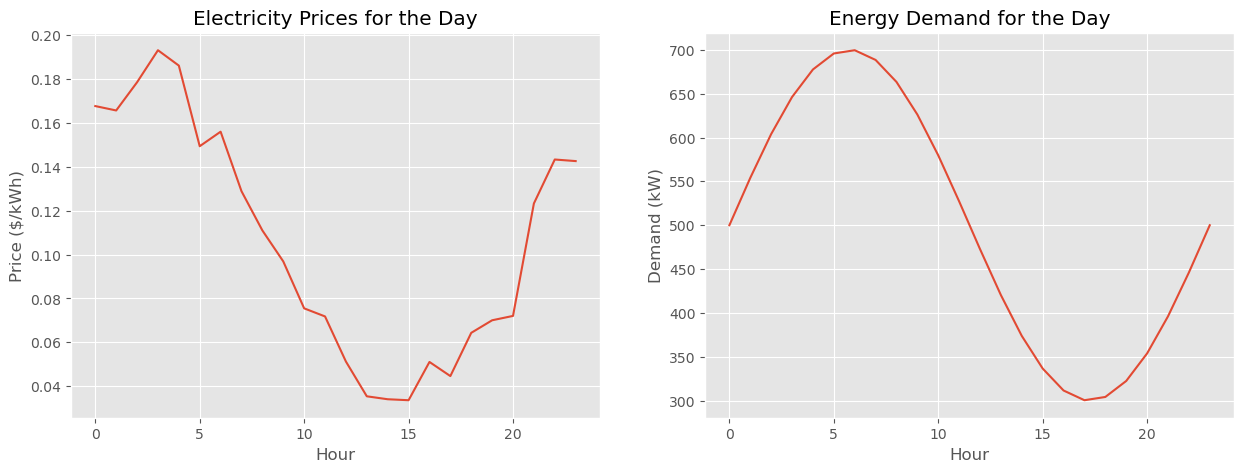

In [102]:
hours_in_day = 24  # 24 hours in a day
np.random.seed(0)  # For reproducibility

# Electricity prices ($/kWh)
base_price = 0.1  # Base price
daily_variation = 0.05 * np.sin(np.linspace(0, 2 * np.pi, 24))  # Daily fluctuation
seasonal_variation = 0.05 * np.cos(np.linspace(0, 2 * np.pi, hours_in_day))  # Seasonal fluctuation
random_variation = 0.01 * np.random.randn(hours_in_day)  # Random noise
electricity_prices = base_price + daily_variation + seasonal_variation + random_variation

# Eenergy demand (kW)
base_demand = 500  # Average demand
daily_demand_variation = 200 * np.sin(np.linspace(0, 2 * np.pi, 24))  # Daily fluctuation
demand = np.maximum(0, base_demand + daily_demand_variation)

# Plotting the results
plt.figure(figsize=(15, 5))

# Plotting electricity prices for the day
plt.subplot(1, 2, 1)
plt.plot(electricity_prices[:24])  # Plot the entire day (24 hours)
plt.title('Electricity Prices for the Day')
plt.xlabel('Hour')
plt.ylabel('Price ($/kWh)')

# Plotting energy demand for the day
plt.subplot(1, 2, 2)
plt.plot(demand[:24])  # Plot the entire day (24 hours)
plt.title('Energy Demand for the Day')
plt.xlabel('Hour')
plt.ylabel('Demand (kW)')

plt.show()


**Step 3: Defining Parameters**


In [103]:
battery_capacity = 1000  # kWh
charge_rate = 100  # kW
discharge_rate = 100  # kW
charge_efficiency = 0.9
discharge_efficiency = 0.9
initial_soc = battery_capacity * 0.5  # 50% initial charge

**Step 4: Creating the Model**

In [104]:
mdl = Model("Battery Scheduling")

charging = mdl.continuous_var_list(hours_in_day, name='charge', lb=0, ub=charge_rate)
discharging = mdl.continuous_var_list(hours_in_day, name='discharge', lb=0, ub=discharge_rate)
soc = mdl.continuous_var_list(hours_in_day, name='soc', lb=0, ub=battery_capacity)

**Step 5: Setting the Objective Function**

In [105]:
cost = mdl.sum(electricity_prices[t] * (demand[t] - discharging[t] + charging[t]) for t in range(hours_in_day))
mdl.minimize(cost)

**Step 6: Adding Constraints**

In [106]:
for t in range(hours_in_day):
    mdl.add_constraint(demand[t] - discharging[t] + charging[t] >= 0)

for t in range(1, hours_in_day):
    mdl.add_constraint(soc[t] == soc[t - 1] + charging[t - 1] * charge_efficiency - discharging[t - 1] / discharge_efficiency)

mdl.add_constraint(soc[0] == initial_soc)
mdl.add_constraint(soc[-1] == initial_soc)

docplex.mp.LinearConstraint[](soc_23,EQ,500.0)

**Step 7: Solving the Model and Analyzing the Results**

In [107]:
solution = mdl.solve(log_output=True)
if solution:
    print("Solution found!")
    charging_schedule = solution.get_values(charging)
    discharging_schedule = solution.get_values(discharging)
    soc_schedule = solution.get_values(soc)
    
    # Optimal solution insights
    total_cost_with_battery = solution.objective_value
    print(f"Total Cost with Battery: ${total_cost_with_battery:.2f}")
    
    # Calculate the cost without the battery
    total_cost_without_battery = sum(electricity_prices[t] * demand[t] for t in range(hours_in_day))
    print(f"Total Cost without Battery: ${total_cost_without_battery:.2f}")
    
    # Calculate and report the cost savings
    cost_savings = total_cost_without_battery - total_cost_with_battery
    print(f"Cost Savings with Battery: ${cost_savings:.2f}")
    
    # Optimal charging and discharging times
    print("\nOptimal Charging (kW) and Times:")
    for t, charge in enumerate(charging_schedule):
        if charge > 0:
            print(f"Hour {t}: Charge {charge:.2f} kW")
    
    print("\nOptimal Discharging (kW) and Times:")
    for t, discharge in enumerate(discharging_schedule):
        if discharge > 0:
            print(f"Hour {t}: Discharge {discharge:.2f} kW")
    
    # Final State of Charge
    print(f"\nFinal State of Charge: {soc_schedule[-1]:.2f} kWh")
else:
    print("No solution found.")

Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 26 rows and 4 columns.
Aggregator did 8 substitutions.
Reduced LP has 15 rows, 60 columns, and 74 nonzeros.
Presolve time = 0.00 sec. (0.06 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =          1148.715755
Solution found!
Total Cost with Battery: $1313.02
Total Cost without Battery: $1396.10
Cost Savings with Battery: $83.09

Optimal Charging (kW) and Times:
Hour 11: Charge 2.47 kW
Hour 12: Charge 100.00 kW
Hour 13: Charge 100.00 kW
Hour 14: Charge 100.00 kW
Hour 15: Charge 100.00 kW
Hour 16: Charge 100.00 kW
Hour 17: Charge 100.00 kW
Hour 18: Charge 100.00 kW
Hour 19: Charge 100.00 kW

Optimal Discharging (kW) and Times:
Hour 0: Discharge 100.00 kW
Hour 1: Discharge 50.00 kW
Hour 2: Discharge 100.00 kW
Hour 3: Discharge 100.00 kW
Hour 4: Discharge 100.00 kW
Hour 21: Discharge 

**Step 8: Plotting the results**

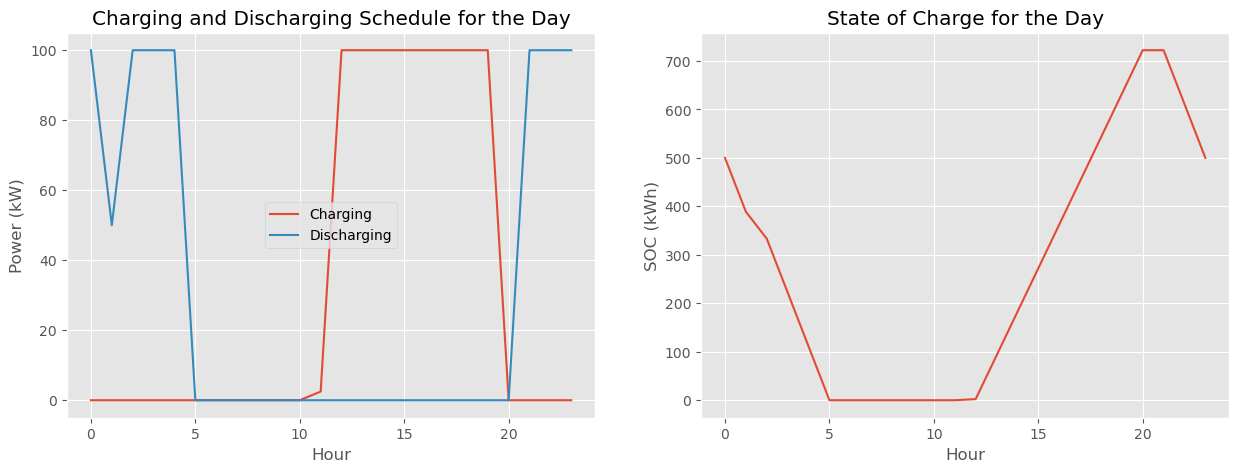

In [108]:
# Plot the results
plt.figure(figsize=(15, 5))

# Plotting charging and discharging schedule for the day
plt.subplot(1, 2, 1)
plt.plot(charging_schedule, label='Charging')
plt.plot(discharging_schedule, label='Discharging')
plt.title('Charging and Discharging Schedule for the Day')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.legend()

# Plotting state of charge for the day
plt.subplot(1, 2, 2)
plt.plot(soc_schedule)
plt.title('State of Charge for the Day')
plt.xlabel('Hour')
plt.ylabel('SOC (kWh)')

plt.show()

# DISCUSSION

**1. Cost Analysis:** 

Total Cost with Battery (1313.02): This is the total electricity cost for the day when using the battery to store and release energy strategically. It reflects the cost of drawing power from the grid minus the returns from discharging the battery when prices are high.
Total Cost without Battery (1396.10): This represents what the electricity cost would have been for the same period without any battery storage, i.e., if all energy was bought directly from the grid as needed.
Cost Savings with Battery (83.09): This is the economic benefit of using the battery. It's a significant saving and indicates that the battery system is effectively reducing energy costs by shifting energy use from more expensive to cheaper times.

**2. Operational Insights:**

Optimal Charging Times: The battery is mostly charged during midday (from hour 11 to hour 19). This might correspond to periods of lower electricity prices, possibly due to high solar generation or lower demand. By charging at these times, the model is capitalizing on cheaper energy to store for later use.
Optimal Discharging Times: Discharging primarily happens during early morning hours (from hour 0 to hour 4) and late evening (from hour 21 to hour 23). These are likely periods of higher electricity prices, possibly due to higher demand or lower renewable generation. Discharging the battery at these times offsets the need to purchase more expensive grid electricity.

**3. Battery Utilization:**

Charging Behavior: The battery charges to its maximum rate (100 kW) for most of the afternoon hours. This indicates that it's beneficial to fill the battery quickly during low-cost periods.
Discharging Behavior: Discharge also occurs at the maximum rate during certain hours, especially when the demand is presumably high or the electricity price is high. This maximizes the financial return of the stored energy.
Final State of Charge (500 kWh): The battery ends up at half its capacity. This balance suggests the model is keeping some energy in reserve, possibly to ensure it can meet demand or take advantage of price fluctuations the next day.

# App Interface 

**Instructions for Use:**


Input Data: Enter the electricity prices and demand for each hour in the corresponding text areas. The values should be separated by commas.
Set Battery Parameters: Adjust the sliders to reflect your battery's capacity, charge/discharge rates, and efficiencies.
Run Optimization: Click the "Run Optimization" button to execute the model with the current inputs.
View Results: Observe the total cost and the charging/discharging schedule plotted below the button after running.

In [109]:
# Import necessary libraries
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define the optimization function
def run_optimization(electricity_prices, demand, battery_params):
    # Unpack battery parameters
    battery_capacity, charge_rate, discharge_rate, charge_efficiency, discharge_efficiency = battery_params

    # Define the model
    mdl = Model("Battery Scheduling")

    # Decision variables
    hours_in_day = len(electricity_prices)  # Assuming the length of electricity_prices represents the hours in a day
    charging = mdl.continuous_var_list(hours_in_day, name='charge', lb=0, ub=charge_rate)
    discharging = mdl.continuous_var_list(hours_in_day, name='discharge', lb=0, ub=discharge_rate)
    soc = mdl.continuous_var_list(hours_in_day, name='soc', lb=0, ub=battery_capacity)

    # Objective: Minimize the cost of electricity
    cost = mdl.sum(electricity_prices[t] * (demand[t] - discharging[t] + charging[t]) for t in range(hours_in_day))
    mdl.minimize(cost)

    # Constraints
    for t in range(hours_in_day):
        mdl.add_constraint(demand[t] - discharging[t] + charging[t] >= 0)

    for t in range(1, hours_in_day):
        mdl.add_constraint(soc[t] == soc[t - 1] + charging[t - 1] * charge_efficiency - discharging[t - 1] / discharge_efficiency)

    mdl.add_constraint(soc[0] == soc[-1])  # Ensuring the final SOC is the same as the initial

    # Solve the model
    solution = mdl.solve()

    if solution:
        # Extract the solution
        charging_schedule = solution.get_values(charging)
        discharging_schedule = solution.get_values(discharging)
        soc_schedule = solution.get_values(soc)
        total_cost = solution.objective_value
        return charging_schedule, discharging_schedule, soc_schedule, total_cost
    else:
        return None, None, None, None

# Create widgets for user input
price_input = widgets.Textarea(value='0.1, 0.2, ..., 0.1', description='Prices:', disabled=False)
demand_input = widgets.Textarea(value='500, 600, ..., 500', description='Demand:', disabled=False)

# Widgets for battery parameters
capacity_input = widgets.FloatSlider(value=1000, min=500, max=5000, step=100, description='Capacity (kWh):')
charge_rate_input = widgets.FloatSlider(value=100, min=50, max=500, step=10, description='Charge Rate (kW):')
discharge_rate_input = widgets.FloatSlider(value=100, min=50, max=500, step=10, description='Discharge Rate (kW):')
charge_efficiency_input = widgets.FloatSlider(value=0.9, min=0.7, max=1.0, step=0.01, description='Charge Efficiency:')
discharge_efficiency_input = widgets.FloatSlider(value=0.9, min=0.7, max=1.0, step=0.01, description='Discharge Efficiency:')

# Button to run the optimization
run_button = widgets.Button(description='Run Optimization')

# Output area for the results
output = widgets.Output()

# Define the button click callback function
def on_run_clicked(b):
    with output:
        clear_output()

        # Convert inputs to the correct format
        prices = np.fromstring(price_input.value, sep=',')
        demand = np.fromstring(demand_input.value, sep=',')
        battery_params = (capacity_input.value, charge_rate_input.value, discharge_rate_input.value, 
                          charge_efficiency_input.value, discharge_efficiency_input.value)
        
        # Run the optimization
        charge, discharge, soc, total_cost = run_optimization(prices, demand, battery_params)
        
        if charge is not None:
            # Display the results
            print(f'Total Cost with Battery: ${total_cost:.2f}')
            plt.figure(figsize=(10, 6))
            plt.plot(charge, label='Charging')
            plt.plot(discharge, label='Discharging')
            plt.plot(soc, label='State of Charge')
            plt.legend()
            plt.title('Optimization Results')
            plt.xlabel('Hour')
            plt.ylabel('kW/kWh')
            plt.show()
        else:
            print("Optimization failed. Please check your inputs.")

# Attach the callback function to the run button
run_button.on_click(on_run_clicked)

# Display the widgets
input_widgets = widgets.VBox([price_input, demand_input, 
                              capacity_input, charge_rate_input, discharge_rate_input, 
                              charge_efficiency_input, discharge_efficiency_input, 
                              run_button])

display(input_widgets, output)


Output()